# Snow Analysis
### Purpose
This notebook will look at volunteer trends for reporting snow, adressing the Github issue #54  
(this notebook is a copy of the rain analysis notebook, but with `%s/rain/snow/g`)

### Author: 
Hamza El-Saawy
### Date: 
2020-08-10
### Update Date: 
2020-08-10

### Inputs 
 - `1.3-rec-connecting-fips-ecosystem-data.txt`

### Output Files
None

## Steps or Proceedures in the notebook 
 - Clean the CBC ecological data 
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
n/a

## Notes
In addition to considerations from the rain analysis notebook, this notebook looks only at snowfall (`am/pm_snow` for volunteers and `snow` for GHCN) and not snowdepth (`min/max_snow` for volunteers and `snwd` for GHCN) as the latter will likely be highly location, ecosystem, and elevation dependant.  
Additionally, it is unclear if volunteers are being asked to measure the snowdepth during the shift or the amount of snow that was on the ground when they arrived/left.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scipy.stats as stats

In [3]:
import sklearn.metrics as metrics

In [4]:
sns.set(style="darkgrid")

In [5]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

In [6]:
#
# 
#

# drop all stations farther than this threshold (meters)
#  16km ~= 10 mi
DISTANCE_THRESHOLD = 15000

# drop all stations farther than this threshold (meters) in elevation
#  the farthest is 3.5km, with the mean being 70m and median being 23m
ELEVATION_THRESHOLD = 50

# consider stations to consense on a snow value if a fraction of them or more all have the same reading
# at the most abiguous, the fraction will be 0.5, so values are symmetric around 1/2: 0.25 in agreement is the same as 0.75 agreeing on the opposite
AGREEMENT_THRESHOLD = 0.75
AGREEMENT_THRESHOLD = max(AGREEMENT_THRESHOLD, 1 - AGREEMENT_THRESHOLD)

In [7]:
DATA_PATH = '../data/Cloud_Data'
ECO_DATA_PATH =  os.path.join(DATA_PATH, '1.3-rec-connecting-fips-ecosystem-data.txt')

In [8]:
eco_data = pd.read_csv(ECO_DATA_PATH, encoding = "ISO-8859-1", sep="\t")
eco_data = eco_data.rename(columns={'circle_name': 'c_name', 'circle_id': 'c_id',
                                    'lat': 'c_lat', 'lon': 'c_lon', 'circle_elev': 'c_elev',
                                    'Ecosys_circle': 'c_ecosys', 'Nlcd_code_circle': 'c_nlcdcode',
                                    'id': 's_id', 'latitude': 's_lat', 'longitude': 's_lon', 'elevation': 's_elev',
                                    'Ecosys_station': 's_ecosys', 'Nlcd_code_station': 's_nlcdcode',})

/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (62,64,65,71,73,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
# drop all the other data that wont be needed
prcp_data = eco_data.loc[:, ['count_date', 'c_name', 'country_state', 'c_id', 'c_lat', 'c_lon',
                              'am_snow', 'pm_snow', 'c_elev', 'c_ecosys', 'c_nlcdcode',
                              's_id', 's_lat', 's_lon', 's_elev', 's_ecosys', 's_nlcdcode','snow',
                             ]]

## Data Prep

#### stations

In [22]:
# pd.NA preserved int-ness of bools, so they are not converted to floats, and supports three-valued (kleene) logic
prcp_data['s_snow'] = np.where(prcp_data.snow.isna(), pd.NA, prcp_data.snow > 0)

#### volunteer records

`[am|pm]_snow` are strings containing `1`:`4`, for heavy, light, none, or unknow snow.  
If the string contains `4`, then -- regardless of observations in that string (e.g. `2,4`) -- it will be marked as `NaN`  
If the string contains either `1` or `2` in the am or pm, then there was precipitation that day.   
If both am and pm are `3`, then there was no precipitation that day.  
Else, we mark `nan`

In [24]:
for c in ['am_snow', 'pm_snow']:
    prcp_data.loc[prcp_data[c].isna(), c] = pd.NA
    prcp_data.loc[prcp_data[c].str.contains('4', na=False), c] = pd.NA

In [25]:
prcp_data['c_snow'] = pd.NA

prcp_data.loc[(prcp_data.am_snow.str.contains('[12]', na=False) | prcp_data.pm_snow.str.contains('[12]', na=False)), 'c_snow'] = True
prcp_data.loc[((prcp_data.am_snow == '3') & (prcp_data.pm_snow == '3')), 'c_snow'] = False

## comparing stations and circles

In [27]:
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)

In [28]:
prcp_data['d_elev'] = np.abs(prcp_data.s_elev - prcp_data.c_elev)

In [29]:
# convert to int array to get nullable boolean arrays
#  https://pandas.pydata.org/pandas-docs/stable/user_guide/boolean.html#kleene-logical-operations
prcp_data['same_ecosys'] = prcp_data.c_ecosys.astype('Int64') == prcp_data.s_ecosys.astype('Int64')
prcp_data['same_nlcd'] = prcp_data.c_nlcdcode.astype('Int64') == prcp_data.s_nlcdcode.astype('Int64')

## data clean up

In [30]:
# drop everything outside of the distance or elevation threshold
prcp_data.drop(prcp_data[prcp_data.distance > DISTANCE_THRESHOLD].index, inplace=True)
prcp_data.drop(prcp_data[prcp_data.d_elev > ELEVATION_THRESHOLD].index, inplace=True)

In [31]:
# once again dump excess data
prcp_data.drop(columns=['am_snow', 'pm_snow','c_elev', 'c_ecosys', 'c_nlcdcode', 
                        's_elev', 's_ecosys', 's_nlcdcode','snow',], inplace=True)

In [32]:
# isolate only the circle specific volunteer data
circle_obs = prcp_data[['count_date', 'c_name', 'country_state', 
                        'c_id', 'c_lat', 'c_lon','c_snow']].groupby(['c_id', 'count_date']).agg('first')

In [33]:
# sort by circle then station information
prcp_data = prcp_data.set_index(['c_id', 'count_date', 's_id']).sort_index()

# snow analysis

In [35]:
g = prcp_data.groupby(level=['c_id', 'count_date'])

In [36]:
def snow_calc(dfg):
    is_na = dfg.s_snow.isna()

    # there can be weirdness with boolean not being promoted to ints, so add zero
    num = dfg.s_snow.size + 0
    num_notna = dfg.s_snow.count() + 0
    num_true = dfg.s_snow.sum() + 0
    
    e = dfg.loc[dfg.same_ecosys, 's_snow']
    e_num = e.size + 0
    e_num_notna = e.count() + 0
    e_num_true = e.sum() + 0
    
    n = dfg.loc[dfg.same_nlcd, 's_snow']
    n_num = n.size + 0
    n_num_notna = n.count() + 0
    n_num_true = n.sum() + 0
    
    # havent figured out how to inlinse this yet ...
    lowest_id = dfg.d_elev.idxmin() if (num > 0) else np.NaN
    lowest_id_na = dfg.loc[~is_na, 'd_elev'].idxmin() if (num_notna > 0) else np.NaN
    
    return pd.Series({
        'num' : num,
        'num_notna' : num_notna,
        'num_true' : num_true,
        
        'e_num' : e_num,
        'e_num_notna' : e_num_notna,
        'e_num_true' : e_num_true,
        
        'n_num' : n_num,
        'n_num_notna' : n_num_notna,
        'n_num_true' : n_num_true,

        'p' : num_true / num_notna if (num_notna > 0) else np.NaN,
        'e_p' : e_num_true / e_num_notna if (e_num_notna > 0) else np.NaN,
        'n_p' : n_num_true / n_num_notna if (n_num_notna > 0) else np.NaN,
        
        'snow_closest' : dfg.loc[dfg.distance.idxmin(), 's_snow'] if (num > 0) else pd.NA,
        'snow_closest_notna' : dfg.loc[dfg.loc[~is_na, 'distance'].idxmin(), 's_snow'] if (num_notna > 0) else pd.NA,
        
        'snow_lowest' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 's_snow'],
        'snow_lowest_notna' : pd.NA if pd.isna(lowest_id_na) else dfg.loc[lowest_id_na, 's_snow'],
    })


In [37]:
circle_data = g.apply(snow_calc)

In [38]:
circle_data = circle_obs.join(circle_data)

In [39]:
# if the stations couldnt agree (p ∈ [1-AGREEMENT_THRESHOLD, AGREEMENT_THRESHOLD]) or p is NaN, set the consenus to NaN as well
circle_data['consensus'] = np.where(((circle_data.p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.p <= AGREEMENT_THRESHOLD)) | circle_data.p.isna(), 
                                     pd.NA, circle_data.p >= AGREEMENT_THRESHOLD)

circle_data['e_consensus'] = np.where(((circle_data.e_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.e_p <= AGREEMENT_THRESHOLD)) | circle_data.e_p.isna(), 
                                     pd.NA, circle_data.e_p >= AGREEMENT_THRESHOLD)

circle_data['n_consensus'] = np.where(((circle_data.n_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.n_p <= AGREEMENT_THRESHOLD)) | circle_data.n_p.isna(), 
                                     pd.NA, circle_data.n_p >= AGREEMENT_THRESHOLD)

In [40]:
for c in ['consensus', 'e_consensus', 'n_consensus', 'snow_closest', 'snow_closest_notna', 'snow_lowest', 'snow_lowest_notna']:
    circle_data[c] = circle_data[c].astype('boolean')

## total stats

### the number of stations per circle

In [41]:
circle_data.num.describe()

count    68390.000000
mean         6.025808
std          7.684488
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        101.000000
Name: num, dtype: float64

Text(0.5, 0, 'number of stations')

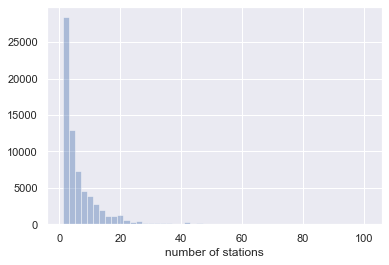

In [43]:
sns.distplot(circle_data.num, kde=False).set_xlabel("number of stations")

### the number of non-NaN stations per circle

In [44]:
circle_data.num_notna.describe()

count    68390.000000
mean         0.866486
std          1.154033
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         30.000000
Name: num_notna, dtype: float64

Text(0.5, 0, 'number of non-NaN stations')

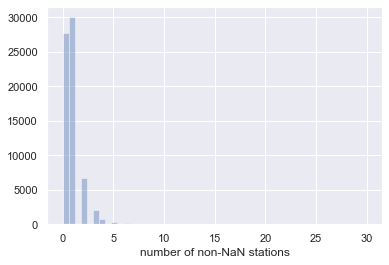

In [45]:
sns.distplot(circle_data.num_notna, kde=False).set_xlabel("number of non-NaN stations")

Text(0.5, 1.0, 'cumulative percent of stations missing')

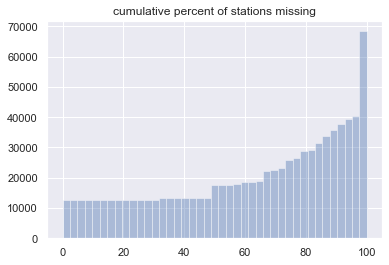

In [46]:
sns.distplot((1 - circle_data.num_notna/circle_data.num) * 100, kde=False, hist_kws={'cumulative': True}).set_title('cumulative percent of stations missing')

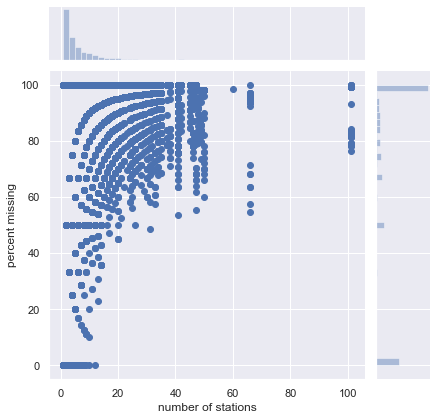

In [47]:
sns.jointplot(circle_data.num, (1 - circle_data.num_notna/circle_data.num) * 100).set_axis_labels("number of stations", 'percent missing')

#### percent of circles where all stations are missing data

In [48]:
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

40.67407515718672

#### percent of circles where no stations are missing data

In [49]:
((circle_data.num_notna == circle_data.num) & (circle_data.num > 0)).sum() / len(circle_data) * 100

18.268752741628894

#### percent of circles with less than half of stations missing

In [50]:
((circle_data.num_notna / circle_data.num) >= 0.5).sum() / len(circle_data) * 100

25.851732709460446

## the number of stations per circle by ecosystem

In [51]:
circle_data.n_num.describe()

count    68390.000000
mean         2.174675
std          3.956987
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         52.000000
Name: n_num, dtype: float64

In [52]:
circle_data.e_num.describe()

count    68390.000000
mean         1.517225
std          2.816323
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         26.000000
Name: e_num, dtype: float64

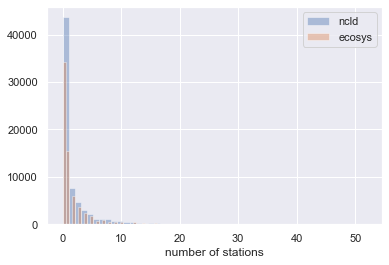

In [53]:
sns.distplot(circle_data.n_num, kde=False)
ax = sns.distplot(circle_data.e_num, kde=False)
ax.set_xlabel("number of stations")
ax.legend(["ncld", "ecosys"])

### the number of non-NaN stations per circle

In [54]:
circle_data.n_num_notna.describe()

count    68390.000000
mean         0.483331
std          0.966960
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         30.000000
Name: n_num_notna, dtype: float64

In [55]:
circle_data.e_num_notna.describe()

count    68390.000000
mean         0.337681
std          0.728628
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         15.000000
Name: e_num_notna, dtype: float64

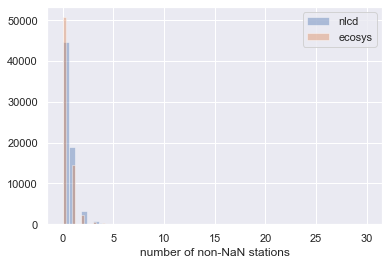

In [56]:
sns.distplot(circle_data.n_num_notna, kde=False)
ax = sns.distplot(circle_data.e_num_notna, kde=False)
ax.set_xlabel("number of non-NaN stations")
ax.legend(["nlcd", "ecosys"])

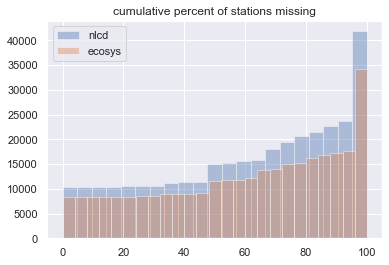

In [57]:
sns.distplot((1 - circle_data.n_num_notna/circle_data.n_num) * 100, kde=False, hist_kws={'cumulative': True})
ax = sns.distplot((1 - circle_data.e_num_notna/circle_data.e_num) * 100, kde=False, hist_kws={'cumulative': True})
ax.set_title('cumulative percent of stations missing')
ax.legend(["nlcd", "ecosys"])

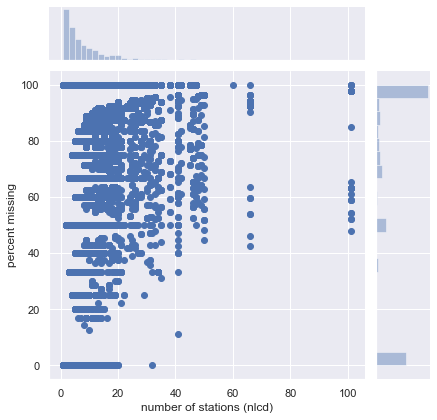

In [58]:
sns.jointplot(circle_data.num, (1 - circle_data.n_num_notna/circle_data.n_num) * 100).set_axis_labels("number of stations (nlcd)", 'percent missing')

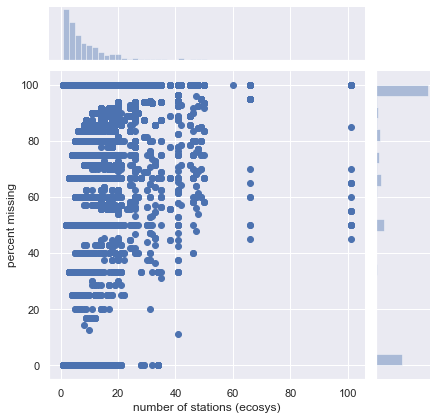

In [59]:
sns.jointplot(circle_data.num, (1 - circle_data.e_num_notna/circle_data.e_num) * 100).set_axis_labels("number of stations (ecosys)", 'percent missing')

#### percent of circles where all stations are missing data

In [60]:
(circle_data.n_num_notna == 0).sum() / len(circle_data) * 100

65.17327094604475

In [61]:
(circle_data.e_num_notna == 0).sum() / len(circle_data) * 100

74.18189793829507

#### percent of circles where no stations are missing data

In [62]:
((circle_data.n_num_notna == circle_data.n_num) & (circle_data.n_num > 0)).sum() / len(circle_data) * 100

15.250767656090073

In [63]:
((circle_data.e_num_notna == circle_data.e_num) & (circle_data.e_num > 0)).sum() / len(circle_data) * 100

12.203538529024712

#### percent of circles with less than half of stations missing

In [64]:
((circle_data.n_num_notna / circle_data.n_num) >= 0.5).sum() / len(circle_data) * 100

22.02222547156017

In [65]:
((circle_data.e_num_notna / circle_data.e_num) >= 0.5).sum() / len(circle_data) * 100

17.00979675391139

## location, location, location

#### what percent of circles had the closest station as NaN?

In [66]:
circle_data.snow_closest.isna().sum() / len(circle_data) * 100

69.76750986986401

#### what percent had the average value differ from the closest value (ignoring NaNs)?

In [67]:
# use kleene logical indexing to skip over NAs
(circle_data.snow_closest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.016084222839596433

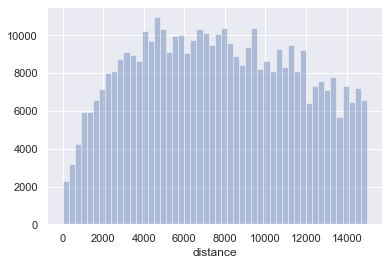

In [68]:
sns.distplot(prcp_data.distance, kde=False)

## elevation, elevation, elevation

#### what percent of circles had the lowest station as NaN?

In [69]:
circle_data.snow_lowest.isna().sum() / len(circle_data) * 100

70.2061704927621

#### what percent had the average value differ from the lowest value (ignoring NaNs)?

In [70]:
# use kleene logical indexing to skip over NAs
(circle_data.snow_lowest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.020470829068577275

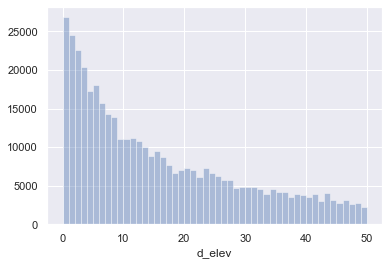

In [71]:
sns.distplot(prcp_data.d_elev, kde=False)

## consensus of stations
we use `4 * p(1-p)` to estiamte the "disagreement" amongst stations: this value ranges from `0` (all in agrement) to `1` (evenly split)  
(here, `p` is the fraction of non-NaN stations that are `True` for snow)

### all stations

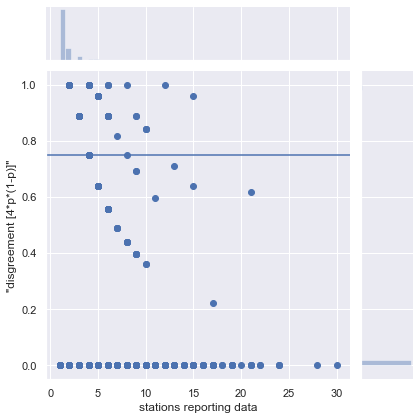

In [72]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p))
p.set_axis_labels("stations reporting data", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [73]:
(circle_data.consensus.isna() & circle_data.p.notna()).sum() / len(circle_data) * 100

1.1843836818248281

### ecosystems

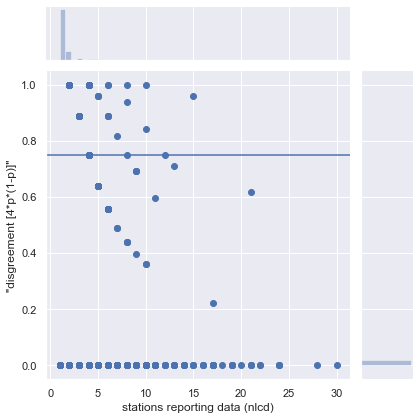

In [74]:
p = sns.jointplot(circle_data.n_num_notna, 4 * circle_data.n_p * (1 - circle_data.n_p))
p.set_axis_labels("stations reporting data (nlcd)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

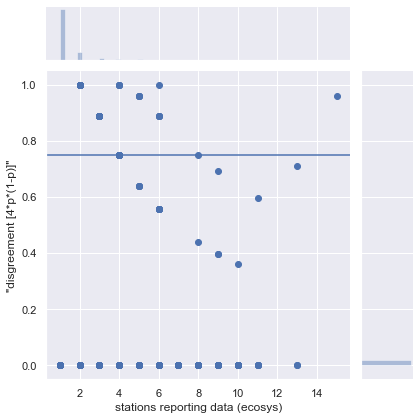

In [75]:
p = sns.jointplot(circle_data.e_num_notna, 4 * circle_data.e_p * (1 - circle_data.e_p))
p.set_axis_labels("stations reporting data (ecosys)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

#### what percent do not meet our dissagreement threshold?

In [76]:
(circle_data.n_consensus.isna() & circle_data.n_p.notna()).sum() / len(circle_data) * 100

0.4752156748062582

In [77]:
(circle_data.e_consensus.isna() & circle_data.e_p.notna()).sum() / len(circle_data) * 100

0.2953648194180436

## the MISSING

In [78]:
circle_data_na_circle_idx = circle_data.c_snow.isna()

### percent of circles with missing snow observation

In [79]:
circle_data_na_circle_idx.sum() / len(circle_data) * 100

62.070478140078954

### percent of circles with both volunteer and all station data are missing

In [80]:
# joint
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / len(circle_data) * 100

23.402544231612808

In [81]:
# conditional 
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / circle_data_na_circle_idx.sum() * 100

37.70318021201414

In [82]:
# population
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

40.67407515718672

correlation between the two

In [83]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna == 0))
g, p

(409.04235366458045, 5.923550141181931e-91)

if the circle is missing data, it is much more likely that all other stations will too, when compared to the general population

### percent of circles with both volunteer and the closest station data are missing

In [84]:
# joint
(circle_data_na_circle_idx & circle_data.snow_closest.isna()).sum()  / len(circle_data) * 100

39.74557683871911

In [85]:
# conditional 
(circle_data_na_circle_idx & circle_data.snow_closest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

64.03297997644287

In [86]:
# population
circle_data.snow_closest.isna().sum() / len(circle_data) * 100

69.76750986986401

In [87]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.snow_closest.isna()))
g, p

(1744.1763855536212, 0.0)

if the circle is missing data, it is much **less** likely that the closest station will have missing data, when compared to the general population

### percent of circles with both volunteer and the lowest station data are missing

In [88]:
# joint
(circle_data_na_circle_idx & circle_data.snow_lowest.isna()).sum()  / len(circle_data) * 100

40.38748355022664

In [89]:
# conditional 
(circle_data_na_circle_idx & circle_data.snow_lowest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

65.06713780918729

In [90]:
# population
circle_data.snow_lowest.isna().sum() / len(circle_data) * 100

70.2061704927621

In [91]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.snow_lowest.isna()))
g, p

(1412.4151644159392, 4.2130431115998e-309)

if the circle is missing data, it is much **less** likely that the lowest station will have missing data, when compared to the general population

### number of stations for circles with missing data

In [92]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna)
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(780.9181069474313, 1.2753540324569464e-148)

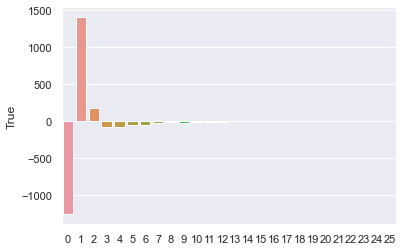

In [93]:
sns.barplot(np.arange(expctd.shape[1]), actl.loc[True] - expctd[1, :])

it looks like the circle being missing implies that there is only one non-na station?

### disagreement

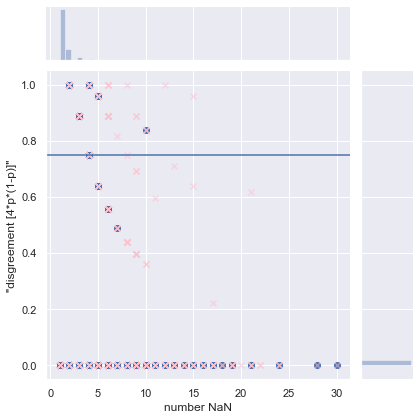

In [94]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.loc[circle_data_na_circle_idx, 'num_notna'], 
                  4 * circle_data.loc[circle_data_na_circle_idx, 'p'] * (1 - circle_data.loc[circle_data_na_circle_idx, 'p']))
p.ax_joint.scatter(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p), color='pink', marker='x', alpha=0.5)
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [95]:
# joint
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / len(circle_data) * 100

23.877759906419065

In [96]:
# conditional
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / circle_data_na_circle_idx.sum() * 100

38.468786808009426

In [97]:
# population
circle_data.consensus.isna().sum() / len(circle_data) * 100

41.858458839011554

In [98]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.consensus.isna())
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(528.0123000722955, 7.645136478036099e-117)

In [99]:
actl - expctd

consensus,False,True
c_snow,,
False,-1438.915777,1438.915777
True,1438.915777,-1438.915777


missing your snow data imples the stations are more likely to consense

# the truth

get a feel for all the different precipitation measures 

how often does it snow?

In [100]:
circle_data.consensus.sum()/ circle_data.consensus.count()

0.1037396574705128

### location & consensus

In [101]:
pd.crosstab(circle_data.consensus, circle_data.snow_closest_notna)

snow_closest_notna,False,True
consensus,,
False,35634,4
True,7,4118


In [102]:
pd.crosstab(circle_data.consensus, circle_data.snow_lowest_notna)

snow_lowest_notna,False,True
consensus,,
False,35520,6
True,8,4071


In [103]:
pd.crosstab(circle_data.snow_closest_notna, circle_data.snow_lowest_notna)

snow_lowest_notna,False,True
snow_closest_notna,,
False,35752,161
True,162,4337


### ecosystem consensus

In [104]:
pd.crosstab(circle_data.consensus, circle_data.n_consensus)

n_consensus,False,True
consensus,,
False,20927,0
True,1,2317


In [105]:
pd.crosstab(circle_data.consensus, circle_data.e_consensus)

e_consensus,False,True
consensus,,
False,15477,0
True,1,1731


In [106]:
pd.crosstab(circle_data.n_consensus, circle_data.e_consensus)

e_consensus,False,True
n_consensus,,
False,15554,0
True,0,1824


### vs the lowest possible bar
(did just one station see snow?)

In [107]:
pd.crosstab(circle_data.snow_closest_notna, circle_data.num_true > 0)

num_true,False,True
snow_closest_notna,,
False,35611,414
True,0,4548


In [108]:
pd.crosstab(circle_data.snow_lowest_notna, circle_data.num_true > 0)

num_true,False,True
snow_lowest_notna,,
False,35499,415
True,0,4498


In [109]:
pd.crosstab(circle_data.consensus, circle_data.num_true > 0)

num_true,False,True
consensus,,
False,35611,27
True,0,4125


In [110]:
pd.crosstab(circle_data.consensus, circle_data.n_num_true > 0)

n_num_true,False,True
consensus,,
False,35617,21
True,1804,2321


In [111]:
pd.crosstab(circle_data.consensus, circle_data.e_num_true > 0)

e_num_true,False,True
consensus,,
False,35624,14
True,2387,1738


# circle v station: the whole point

In [112]:
def crosstab_metrics(actl):
    # accuracy
    acc = actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()
    # precision
    pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
    # recall
    re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
    # F1
    f1 = 2 * pr * re / (pr + re)
    
    print(f"accuracy:  {acc*100:.2f}%")
    print(f"precision: {pr*100:.2f}%")
    print(f"recall:    {re*100:.2f}%")
    print(f"F1:        {f1*100:.2f}%")
    
#     return (acc, pr, re, f1)

### based on the stations' consensus

In [113]:
actl = pd.crosstab(circle_data.consensus, circle_data.c_snow)
actl

c_snow,False,True
consensus,,
False,9009,2124
True,781,1729


In [114]:
crosstab_metrics(actl)

accuracy:  78.71%
precision: 44.87%
recall:    68.88%
F1:        54.35%


### based on the closest station

In [115]:
actl = pd.crosstab(circle_data.snow_closest_notna, circle_data.c_snow)
actl

c_snow,False,True
snow_closest_notna,,
False,9124,2249
True,886,1869


In [116]:
crosstab_metrics(actl)

accuracy:  77.81%
precision: 45.39%
recall:    67.84%
F1:        54.39%


### based on the lowest station

In [117]:
actl = pd.crosstab(circle_data.snow_lowest_notna, circle_data.c_snow)
actl

c_snow,False,True
snow_lowest_notna,,
False,9076,2230
True,888,1842


In [118]:
crosstab_metrics(actl)

accuracy:  77.79%
precision: 45.24%
recall:    67.47%
F1:        54.16%


### based on the nlcd consensus

In [119]:
actl = pd.crosstab(circle_data.n_consensus, circle_data.c_snow)
actl

c_snow,False,True
n_consensus,,
False,5441,1196
True,486,1023


In [120]:
crosstab_metrics(actl)

accuracy:  79.35%
precision: 46.10%
recall:    67.79%
F1:        54.88%


### based on the ecosys consensus

In [121]:
actl = pd.crosstab(circle_data.e_consensus, circle_data.c_snow)
actl

c_snow,False,True
e_consensus,,
False,4061,876
True,397,780


In [122]:
crosstab_metrics(actl)

accuracy:  79.18%
precision: 47.10%
recall:    66.27%
F1:        55.07%


### did atleast one station aggree?

In [123]:
actl = pd.crosstab(circle_data.num_true >= 1, circle_data.c_snow)
actl

c_snow,False,True
num_true,,
False,17291,5630
True,1014,2005


In [124]:
crosstab_metrics(actl)

accuracy:  74.39%
precision: 26.26%
recall:    66.41%
F1:        37.64%
